# A Systematic Framework for Topological Data Analysis on Reticulation Simulations
## Max Mattioli    |    BINF 4007

### Overview
In this project, I created an easy-to-use python module for the analysis of persistent homology on simulated recombinant populations. This work was done in conjunction with and for the lab of Brian Twisto an Sipa Saimatun at Hunter College to explore the effects of different parameter configurations on the persistent homology of SNP mutation matrices of simulated populations.

### Motivation
We investigated this issue because Topological Data Analysis is particularly well equipped to model complex evolutionary trees, moreso than the usual tree structure. We 


**Crossover**
 - When two chromosomes, normally homolo

### Tools Used
#### msHOT
#### 

### Future Work



In [29]:
from scipy.spatial.distance import pdist
import brainiak

In [30]:
from brainiak_extras.tda.rips import rips_filtration

In [31]:
%load_ext rpy2.ipython
%matplotlib inline
from sklearn.externals.joblib import load, dump
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import time
import os
import glob

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [32]:
TIME = time.strftime('%H-%M-%S')
msHOT_PATH = '~/msHOT/'

In [33]:
%%R
get_xy <- function(i){
    return(gcds11[[i]])
}

In [34]:
%%R
library(TDA)
load('columbiaresults4.RData')
TDA <- function(x) {
    distance_mat <- dist(x, method = "manhattan")
    rips_diag <- ripsDiag(distance_mat, maxdimension = 2, maxscale = max(distance_mat), dist = "arbitrary", library = "GUDHI")
    #one <- which(rips_diag[["diagram"]][,1]==1)
    return(rips_diag[["diagram"]])
}

In [35]:
def get_list_of_dir_contents(path, only_fns_with_str='', return_fns_only=False):
    directory_contents = glob.glob(os.path.join(path, '*'))
    dir_contents = []
    for path in directory_contents:
        fn = path.split('/')[-1]
        if only_fns_with_str not in fn:
            continue
        if return_fns_only:
            dir_contents.append(fn)
        else:
            dir_contents.append('/'.join(path.split('/')[:-1] + [fn]))
    return dir_contents

In [36]:
def R_gcds11_to_df(pts):
    py_pts=[]
    for i in pts:
        pt = list(i.transpose())
        if len(pt)==2:
            py_pts.append(pt)
        else:
            print(len(pt), 
                 'huh')
    return py_pts

In [37]:
def write_msHOT(n_simulations=30, size_pop=100, r=.001, size_seq=100001,
                c=100000.0, tract_length=100, s=100):

    FN = 'sims/pop' + str(size_pop) + '_r' + str(r) + '_seqsize' + str(size_seq) + '_c' + str(c) \
            + '_trlen' + str(tract_length) + '_s' + str(s) + '.txt'

    if c is None or tract_length is None:
        cmd = msHOT_PATH + './msHOT ' + str(size_pop) + ' ' + str(n_simulations) \
            + ' -r ' + str(r) + ' ' + str(size_seq) + ' -s ' + str(s) + ' > ' + FN
    else:
        cmd = msHOT_PATH + './msHOT ' + str(size_pop) + ' ' + str(n_simulations) \
            + ' -r ' + str(r) + ' ' + str(size_seq) + ' -c ' + str(c) + ' ' \
            + str(tract_length) + ' -s ' + str(s) + ' > ' + FN
    os.system(cmd)
    return FN

In [38]:
def fixed_window(simulation, window_pct=0.05):
    window_snp_size = int(window_pct * simulation.shape[1])
    left = simulation[:, :window_snp_size]
    right = simulation[:, -window_snp_size:]
    window = np.append(arr=left, values=right, axis=1)
    return window

In [39]:
def load_msHOT(n_simulations=30, size_pop=100, r=100, size_seq=100001,
                c=100000.0, tract_length=100, s=100, path_to_prewritten=None):
    if path_to_prewritten == None:
        fn = write_msHOT(n_simulations, size_pop, r, size_seq, c,
                        tract_length, s)
    else:
        fn = path_to_prewritten
    raw_file = open(fn)
    list_of_sims = raw_file.read().split('\n\n')[2::2]
    processed_sims = []
    for simulation in list_of_sims:
        lines = simulation.strip().split('\n')
        pos = [float(pct) for pct in lines[0].split(' ')[1:-1]]
        snp_rows = []
        for row in lines[1:]:
            snp_rows.append([int(indicator) for indicator in row])
        snp_df = pd.DataFrame(data=snp_rows, columns=pos)
        processed_sims.append(snp_df)
    return processed_sims

In [40]:
def pyTDA(window):
    distmat = pdist(window, 'cityblock')
    rips = rips_filtration(distmat, )
    return rips

In [41]:
def batch_TDA(simulations, window_pct=0.05):
    all_results = []
    for sim in simulations:
        wind = fixed_window(sim.values)
        %R -i wind
        %R -o results results <- TDA(wind)
        print(results)
        all_results.append(list(results.T))
    print(all_results[:5])
    return all_results

In [42]:
def hist_of_b1s(results_pkl_path):
    results = load(results_pkl_path)
    title = results_pkl_path.split('/')[-1].split('.pkl')[0]
    stats_list = []
    for b1s, birth, death in results:
        stats_list.append({'mean': b1s.mean(), 'sd': b1s.std(),
                           'count': b1s.sum()})
    df = pd.DataFrame(stats_list, index=range(len(stats_list)))
    df.index.rename(name='row_num', inplace=True)
    df.to_csv(results_pkl_path[:-4] + '.csv')
    
    fig, ax = plt.subplots()
    ax.hist(df['count'].T, bins='auto')
    fig.set_size_inches(h=8, w=12)
    ax.set_xlabel('Count $B_1s$')
    ax.set_ylabel('Count Simulations')
    ax.set_title('Boundary Windows ' + title)
    fig.savefig(title + '.png')

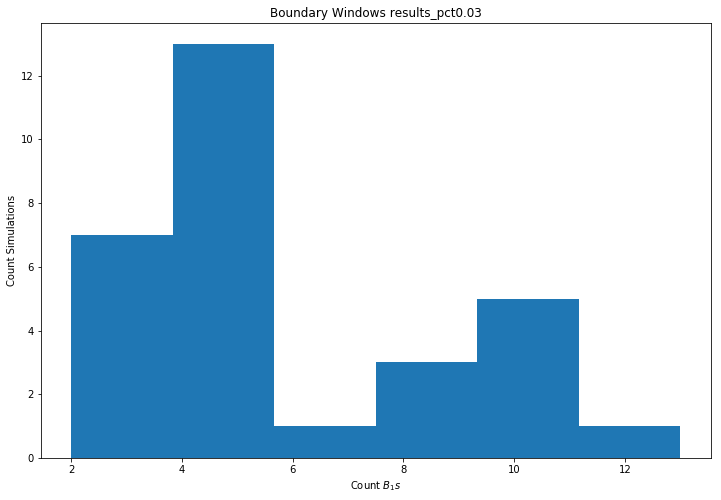

In [16]:
hist_of_b1s('TDA_results/results_pct0.03.pkl')

In [44]:
hist_of_b1s('TDA_results/results_pct0.1.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'TDA_results/results_pct0.1.pkl'

In [ ]:
for pct in [0.1]: #, 0.1, 0.15, 0.2, 0.25][::3]:
    sims = load_msHOT(c=None)
    results = batch_TDA(sims, window_pct=pct)
    dump(results, 'TDA_results/results_pct' + str(pct) + '.pkl')

[[ 0.  0.  6.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  2.]
 [ 0.  0.  1.]
 [ 1.  1.  2.]
 [ 1.  1.  2.]
 [ 1.  1.  2.]]
[[ 0.  0.  6.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  1.  2.]
 [ 1.  1.  2.]
 [ 1.  1.  2.]
 [ 1.  1.  2.]
 [ 1.  1.  2.]
 [ 1.  1.  2.]]
[[ 0.  0.  4.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  1.  2.]
 [ 1.  1.  2.]
 [ 1.  1

[[ 0.  0.  6.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  2.]
 [ 1.  1.  2.]
 [ 1.  1.  2.]
 [ 1.  1.  2.]
 [ 1.  1.  2.]
 [ 1.  1.  2.]]
[[ 0.  0.  8.]
 [ 0.  0.  2.]
 [ 0.  0.  1.]
 [ 0.  0.  2.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  2.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  3.  4.]
 [ 1.  3.  5.]]
[[ 0.  0.  5.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  1.  2.]
 [ 1.  1.  2.]
 [ 1.  1.  2.]
 [ 1.  1.  2.]]


In [ ]:
for c_val in [1000000.0,10000000.0,100000.0][2::3]:
    sims = load_msHOT(c=c_val)
    results = batch_TDA(sims)
    dump(results, 'TDA_results/results_c' + str(c_val) + '.pkl')

In [17]:
m = load_msHOT(path_to_prewritten='/home/max/Desktop/TDA/sims/pop100_r0.001_seqsize100001_c10000.0_trlen100_s100.txt')

In [27]:
pdist(m[0].values, 'cityblock')
k = m[0]
%R -i k
%R -o results results <- TDA(k)

array([ 6.,  2.,  6., ...,  0.,  1.,  1.])

In [28]:
results

array([ 6.,  2.,  6., ...,  0.,  1.,  1.])

In [ ]:
rips_filtration()

In [ ]:
# dump(results, 'results_cross.pkl')

In [ ]:
# np.array(load('results_cross.pkl')).shape

In [ ]:
# all_coords = []
# for i in range(1,301):
#     %R -o pts pts <- get_xy(i)
#     all_coords.append(R_gcds11_to_df(pts))
# coords_array = np.array(all_coords)

In [ ]:
# %%R
# get_xy <- function(i){
#     return(gcds11[[i]])
# }

In [ ]:
# %%R
# gamete.count<-function(datafr) {  
#     datav<-c(rep(0,6))
#     sortdf<-data.frame(1,2,3,4,5,6)
#     colnames(sortdf)<-c("r1","r2","oo","io","oi","ii")
#     for (i in 1:99)  { 
#         for (j in (i+1):100)  {
#           datav[1]<-i
#           datav[2]<-j
#         for (r in 1:100)  {
#           if (datafr[r,i]==0 & datafr[r,j]==0) {
#             datav[3]=datav[3]+1 }
#           if (datafr[r,i]==1 & datafr[r,j]==0) {
#             datav[4]=datav[4]+1 }
#           if (datafr[r,i]==0 & datafr[r,j]==1) {
#             datav[5]=datav[5]+1 }
#           if (datafr[r,i]==1 & datafr[r,j]==1) {
#             datav[6]=datav[6]+1 }

#         }
#       sortdf<-rbind(sortdf,datav)
#       datav<-c(rep(0,6))
#         }
#     }
#     sortdf<-sortdf[-1,]
#     return(four.gametes<- subset(sortdf, oo>0 & io>0 & ii>0 & oi > 0)) 
# }